# Evolutionary Algorithms Lab - Set Covering Problem

Same set covering problem as for laboratory 1.
Problem start and imports.

In [52]:
import logging
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from matplotlib import cm
import random

logging.basicConfig(
    format="[%(asctime)s] %(levelname)s: %(message)s",
    datefmt="%H:%M:%S",
    level=logging.INFO,
)

N_VALUES = [5, 10, 20, 100, 500, 1000]
SEED = 42

def problem(N, seed=SEED):
    random.seed(seed)
    return [
        list(set(random.randint(0, N - 1) for n in range(random.randint(N // 5, N // 2))))
        for n in range(random.randint(N, N * 5))
    ]

Recurring functions to use in all the algorithms.
The fitness evaluation just returns the weight of a single solution.
The tweak function uses a sigma which is not a conventional variance of a normal distribution, but more of a variable to use to get a random number of lists to change in the solution to get the mutated one.
For each mutation there is 50% change that the list doesn't get changed, and for every solution that goes into mutation there is a 10% chance that the solution gets substituted completely by a new valid solution drawn randomly from the pool of lists.

In [53]:
def goal_test(N, solution):
    solution = [x for l in solution for x in l]
    set_sol = set(elem for elem in solution)
    goal = set(range(N))
    return set_sol == goal

def fitness_eval(solution):
        w = sum(len(_) for _ in solution)
        return w

def tweak_sol(solution, all_lists, sigma, N):
    new_solution = set(solution)
    normal = random.randint(0, round(sigma))

    if random.random() < 0.1:
        new_solution = set()
        while not goal_test(N, new_solution):
            new_solution.add(random.choice(list(all_lists - new_solution)))
            
    for mutations in range(normal):
        if random.random() > 0.5:
            new_solution.remove(random.choice(list(new_solution)))
            new_solution.add(random.choice(list(all_lists - new_solution)))

    return new_solution

# 1+1 EA algorithm
Basic 1+1 evolutionary algorithm, each parent generates an offspring, and then competes with it.

In [54]:
def plus1_ea(solution, all_lists, steps, sigma, n):
    
    history = []
    for steps in range(steps):
        max_tweak = 2000
        tweaks = 0
        candidate = tweak_sol(solution, all_lists, sigma, n)
        while not goal_test(n, candidate) and max_tweak > tweaks:
            candidate = tweak_sol(solution, all_lists, sigma, n)
            tweaks += 1
        
        if fitness_eval(candidate) < fitness_eval(solution):
            
            solution = candidate

        history.append(fitness_eval(solution))

    return solution, history


[18:04:12] INFO: N = 5, best solution: w=5 (bloat=0%)
[18:04:12] INFO: N = 10, best solution: w=10 (bloat=0%)
[18:04:12] INFO: N = 20, best solution: w=24 (bloat=20%)
[18:04:13] INFO: N = 100, best solution: w=211 (bloat=111%)
[18:04:19] INFO: N = 500, best solution: w=1663 (bloat=233%)
[18:04:36] INFO: N = 1000, best solution: w=4367 (bloat=337%)


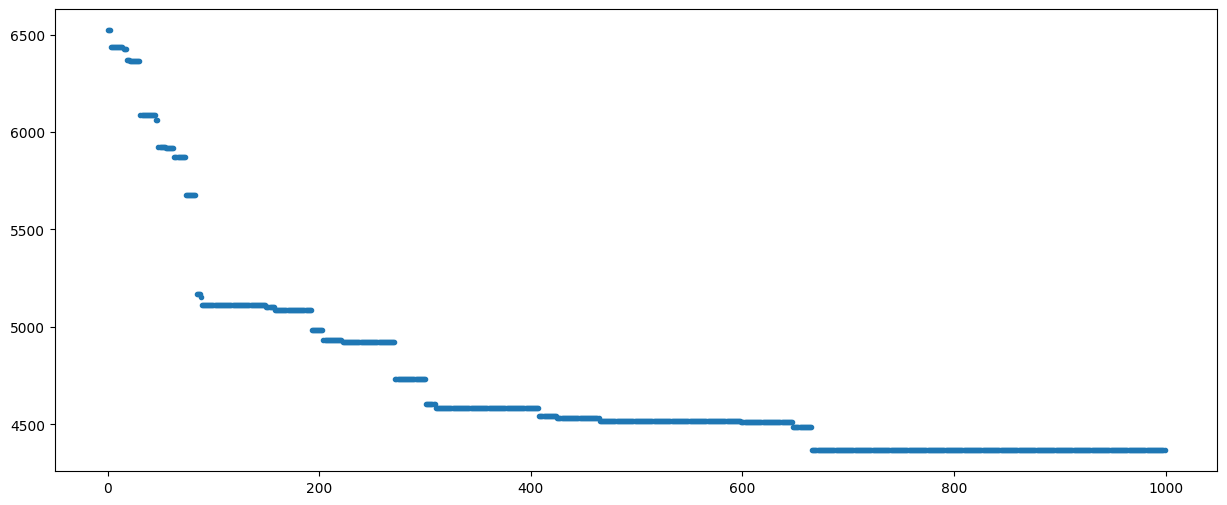

In [55]:
SIGMA = 1
STEPS = 1000

for num in N_VALUES:
    all_lists = set(tuple(element) for element in problem(num, SEED))
    
    random_list = random.choice(list(all_lists))
    
    start_element = set()
    while not goal_test(num, start_element):
      start_element.add(random.choice(list(all_lists - start_element)))
      
  
    sol, history = plus1_ea(start_element, all_lists, STEPS, SIGMA, num)
    
    if num == 1000:
      plt.figure(figsize=(15, 6))
      plt.scatter(range(STEPS), history, marker=".")
    
    logging.info(f"N = {num}, best solution: w={sum(len(_) for _ in sol)} (bloat={(sum(len(_) for _ in sol)-num)/num*100:.0f}%)")
    
           

# 1 + λ Evolution algorithm.
The parent, or the best individual of the previous generation, creates a population of λ offsprings and then competes with them. 

In [56]:
# 1 + λ ES

def plusLambda_ea(solution, all_lists, steps, offspring_size, sigma, n):
    
    history = []
    for steps in range(steps):
        
        offspring = offspring_gen(solution, all_lists, offspring_size, sigma, n)
        evals = []
        for offs in offspring:
            evals.append(fitness_eval(offs))
        solution = offspring[np.argmin(evals)]
        history.append(fitness_eval(solution))

    return solution, history



def offspring_gen(parent, all_lists, offspring_size, sigma, N):
    offspring = [parent]
    for l in range(offspring_size):
        max_tweak = 2000
        tweaks = 0
        new_offspring = tweak_sol(parent, all_lists, sigma, N)
        
        while not goal_test(N, new_offspring) and max_tweak > tweaks:
            new_offspring = tweak_sol(parent, all_lists, sigma, N)
            tweaks += 1
        offspring.append(new_offspring)
    return tuple(offspring)


[18:06:28] INFO: N = 5, best solution: w=5 (bloat=0%)
[18:06:29] INFO: N = 10, best solution: w=10 (bloat=0%)
[18:06:31] INFO: N = 20, best solution: w=24 (bloat=20%)
[18:06:52] INFO: N = 100, best solution: w=208 (bloat=108%)
[18:08:05] INFO: N = 500, best solution: w=1464 (bloat=193%)
[18:12:42] INFO: N = 1000, best solution: w=3705 (bloat=270%)


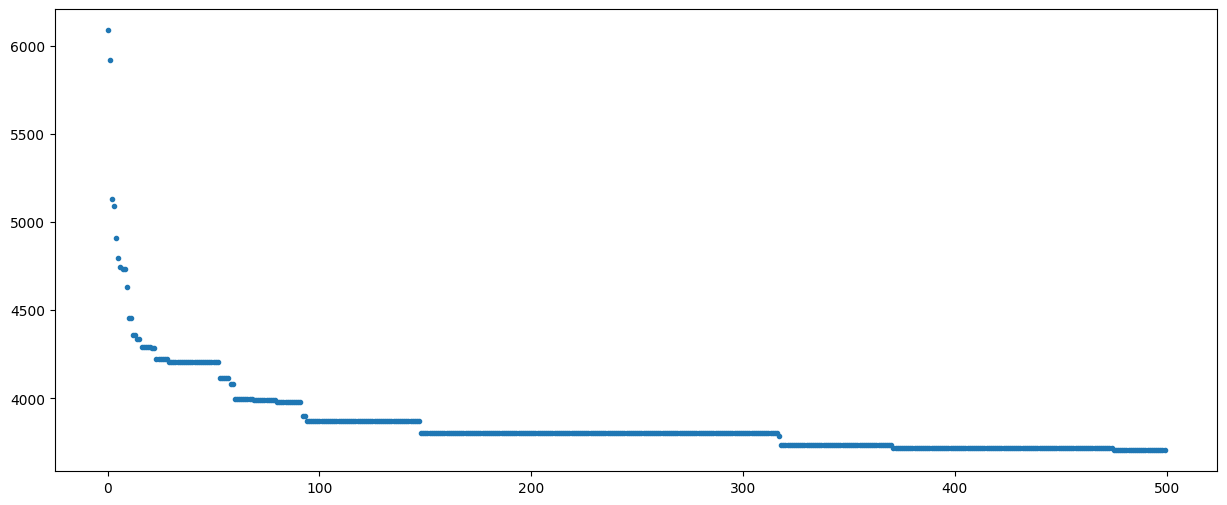

In [57]:
SIGMA = 1
STEPS = 500
OFFSPRING_SIZE = 40

for num in N_VALUES:
    all_lists = set(tuple(element) for element in problem(num, SEED))
    
    random_list = random.choice(list(all_lists))
    
    start_element = set()
    while not goal_test(num, start_element):
      start_element.add(random.choice(list(all_lists - start_element)))
      
    sol, history = plusLambda_ea(start_element, all_lists, STEPS, OFFSPRING_SIZE, SIGMA, num)
    
    if num == 1000:
      plt.figure(figsize=(15, 6))
      plt.scatter(range(STEPS), history, marker=".")
    
    logging.info(f"N = {num}, best solution: w={sum(len(_) for _ in sol)} (bloat={(sum(len(_) for _ in sol)-num)/num*100:.0f}%)")

# 1, λ Evolution algorithm.
The parent, or the best individual of the previous generation, creates a population of λ offsprings and then gets discarded. Then the best of the offspring is the parent of the next generation. 

In [58]:
def commaLambda_ea(solution, all_lists, steps, offspring_size, sigma, n):
    
    history = []
    for steps in range(steps):
        
        offspring = offspring_gen_comma(solution, all_lists, offspring_size, sigma, n)
        evals = []
        for offs in offspring:
            evals.append(fitness_eval(offs))
        solution = offspring[np.argmin(evals)]
        history.append(fitness_eval(solution))

    return solution, history

def offspring_gen_comma(parent, all_lists, offspring_size, sigma, N):
    offspring = []
    for l in range(offspring_size):
        max_tweak = 2000
        tweaks = 0
        new_offspring = tweak_sol(parent, all_lists, sigma, N)
        
        while not goal_test(N, new_offspring) and max_tweak > tweaks:
            new_offspring = tweak_sol(parent, all_lists, sigma, N)
            tweaks += 1
        offspring.append(new_offspring)
    return tuple(offspring)

[18:13:04] INFO: N = 5, best solution: w=5 (bloat=0%)
[18:13:06] INFO: N = 10, best solution: w=10 (bloat=0%)
[18:13:10] INFO: N = 20, best solution: w=24 (bloat=20%)
[18:13:22] INFO: N = 100, best solution: w=185 (bloat=85%)
[18:14:44] INFO: N = 500, best solution: w=1589 (bloat=218%)
[18:18:30] INFO: N = 1000, best solution: w=3613 (bloat=261%)


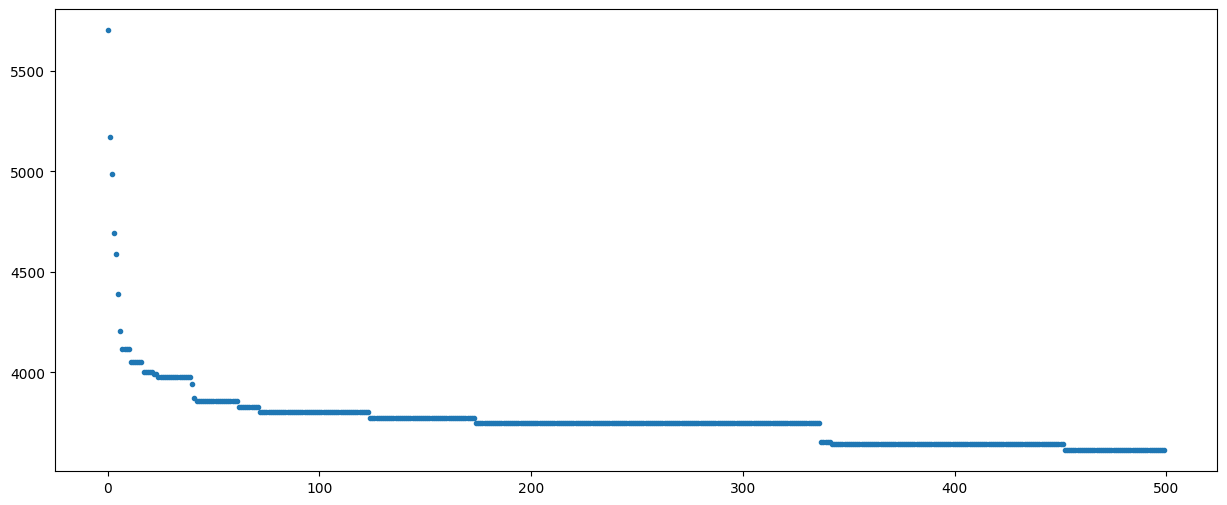

In [59]:
SIGMA = 2
STEPS = 500
OFFSPRING_SIZE = 40

for num in N_VALUES:
    all_lists = set(tuple(element) for element in problem(num, SEED))
    
    random_list = random.choice(list(all_lists))
    
    start_element = set()
    while not goal_test(num, start_element):
      start_element.add(random.choice(list(all_lists - start_element)))
      
    sol, history = commaLambda_ea(start_element, all_lists, STEPS, OFFSPRING_SIZE, SIGMA, num)
    
    logging.info(f"N = {num}, best solution: w={sum(len(_) for _ in sol)} (bloat={(sum(len(_) for _ in sol)-num)/num*100:.0f}%)")
    
    if num == 1000:
      plt.figure(figsize=(15, 6))
      plt.scatter(range(STEPS), history, marker=".")
    
    

# 1, λ Adaptive Evoution algorithm.
The parent, or the best individual of the previous generation, creates a population of λ offsprings and then gets discarded. Then the best of the offspring is the parent of the next generation. It is equal to the previous version except for an adaptation of the "variance" every 100 generations, based on the fact that the fitness doesn't improve since the 10 last generations.

In [60]:
def commaLambda_adaptive_ea(solution, all_lists, steps, offspring_size, sigma, n):
    
    history = []
    for steps in range(steps):
        
        offspring = offspring_gen_comma(solution, all_lists, offspring_size, sigma, n)
        evals = []
        for offs in offspring:
            evals.append(fitness_eval(offs))
        solution = offspring[np.argmin(evals)]
        history.append(fitness_eval(solution))

        if (steps + 1) % 100 == 0:
          if history[-1] == history[-10]:
            sigma /= 0.5
          else:
            sigma *= 0.5
        


    return solution, history

SIGMA = 1
STEPS = 500
OFFSPRING_SIZE = 40

for num in N_VALUES:
    all_lists = set(tuple(element) for element in problem(num, SEED))
    
    random_list = random.choice(list(all_lists))
    
    start_element = set()
    while not goal_test(num, start_element):
      start_element.add(random.choice(list(all_lists - start_element)))
      
    sol, history = commaLambda_adaptive_ea(start_element, all_lists, STEPS, OFFSPRING_SIZE, SIGMA, num)
    
    if num == 1000:
      plt.figure(figsize=(15, 6))
      plt.scatter(range(STEPS), history, marker=".")
    
    logging.info(f"N = {num}, best solution: w={sum(len(_) for _ in sol)} (bloat={(sum(len(_) for _ in sol)-num)/num*100:.0f}%)")

[18:18:33] INFO: N = 5, best solution: w=5 (bloat=0%)
[18:18:36] INFO: N = 10, best solution: w=10 (bloat=0%)
[18:18:40] INFO: N = 20, best solution: w=24 (bloat=20%)
[18:18:55] INFO: N = 100, best solution: w=208 (bloat=108%)
[18:20:50] INFO: N = 500, best solution: w=1466 (bloat=193%)


# mu rho / lambda evolution strategy.
In this algorith both crossover and mutations are used.
The parents are a population of mu.

In [47]:
def crossover(elem1, elem2):
    el1 = list(elem1)
    el2 = list(elem2)
    result_list1 = []
    result_list2 = []

    cut = random.randint(0, min(len(elem1), len(elem2)))
    
    result_list1.append(el2[cut::])
    result_list1.append(el1[0:cut])
    result_list2.append(el1[cut::])
    result_list2.append(el2[0:cut])
    result1 = tuple(element for element in result_list1)
    result2 = tuple(element for element in result_list2)
    return result1, result2

def offspring_gen_mu(parents, all_lists, offspring_size, sigma, rho, N):
    for r in range(rho):
        parent1 = random.choice(list(parents))
        parents.remove(parent1)
        parent2 = random.choice(list(parents))
        parents.remove(parent2)
        parent1, parent2 = crossover(parent1, parent2)
        parents.append(parent1)
        parents.append(parent2)

    offspring = [parents]
    
    for l in range(offspring_size-len(parents)):
        max_tweak = 2000
        tweaks = 0
        parent = tuple((element) for element in random.choice(parents))
        new_offspring = tweak_sol(parent, all_lists, sigma, N)
        
        while not goal_test(N, new_offspring) and max_tweak > tweaks:
            new_offspring = tweak_sol(parent, all_lists, sigma, N)
            tweaks += 1
        offspring.append(new_offspring)
    return tuple(offspring)


In [48]:
def mupluslambda_ea(solution, all_lists, steps, offspring_size, sigma, mu, rho, n):
    history = []
    
    for steps in range(steps):
        
        offspring = offspring_gen_mu(solution, all_lists, offspring_size, sigma, rho, n)
        evals = []
        for offs in offspring:
            evals.append(fitness_eval(offs))

        sort_offspring =[x for _, x in sorted(zip(evals, offspring), key=lambda pair: pair[0])]

        solution = sort_offspring[0:mu]

        history.append(min(evals))

             
    solution = offspring[np.argmin(evals)]
    return solution, history

In [51]:
SIGMA = 1
STEPS = 200
OFFSPRING_SIZE = 40
MU = 4
RHO = 2

for num in N_VALUES:
    all_lists = set(tuple(element) for element in problem(num, SEED))
    
    random_list = random.choice(list(all_lists))
    start = []
    start_element = set()
    while not len(start) == MU:
        while not goal_test(num, start_element):
            start_element.add(random.choice(list(all_lists - start_element)))
        start.append(start_element)
    sol, history = mupluslambda_ea(start, all_lists, STEPS, OFFSPRING_SIZE, SIGMA, MU, RHO, num)
    
    if num == 1000:
      plt.figure(figsize=(15, 6))
      plt.scatter(range(STEPS), history, marker=".")
    
    logging.info(f"N = {num}, best solution: w={sum(len(_) for _ in sol)} (bloat={(sum(len(_) for _ in sol)-num)/num*100:.0f}%)")

TypeError: unhashable type: 'list'